**CS230 Project Milestone**

This notebook implements a UNET model for the semantic segmentation of ~60k synthetic satellite images. Our code closely follows [Kian (2021)'s](https://kiansoon.medium.com/semantic-segmentation-is-the-task-of-partitioning-an-image-into-multiple-segments-based-on-the-356a5582370e) implementation of semantic segmentation for the ADE20K dataset.

In [ ]:
!pip install segmentation_models
!pip install keras.utils --upgrade
!pip install tensorflow==2.6.0
!pip install awscli
!pip install s3fs

In [ ]:
import os
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
from tqdm import tqdm
import random
import shutil
from keras.utils import np_utils

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Tensorflow ver. 2.6.0
Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
# AWS configs
import awscli
import s3fs

In [ ]:
# Declaring a few constants
IMAGE_SIZE = 224 # 224 x 224 images
num_classes = 11 # Ten satellite label parts + background/any other part
batch = 32
LR = 1e-4
EPOCHS = 5

In [ ]:
!aws configure

In [ ]:
ls

sample_data/


In [ ]:
!mkdir semantic-segmentation

In [ ]:
ls

sample_data/  semantic-segmentation/


In [ ]:
# Process all the Cluster II data
!aws s3 cp s3://blender-satellite-renders/stage-clusterII-v0.tar.gz ./stage-clusterII-v0.tar.gz
!tar -xvzf stage-clusterII-v0.tar.gz --directory ./semantic-segmentation
!mkdir ./semantic-segmentation/clusterII_images
!mkdir ./semantic-segmentation/clusterII_masks
!mv ./semantic-segmentation/stage-clusterII-v0/image_*  ./semantic-segmentation/clusterII_images/
!mv ./semantic-segmentation/stage-clusterII-v0/mask_*  ./semantic-segmentation/clusterII_masks/

# Now, append the satellite name at the front of all base images and labeled images
for root, dirs, files in os.walk("semantic-segmentation/clusterII_images"):
    if not files:
        continue
    prefix = "ClusterII"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/clusterII_masks"):
    if not files:
        continue
    prefix = "ClusterII"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

In [ ]:
# Do the same for NEAR
!aws s3 cp s3://blender-satellite-renders/stage-NEAR-v0.tar.gz ./stage-NEAR-v0.tar.gz
!tar -xvzf stage-NEAR-v0.tar.gz --directory ./semantic-segmentation
!mkdir ./semantic-segmentation/NEAR_images
!mkdir ./semantic-segmentation/NEAR_masks
!mv ./semantic-segmentation/stage-NEAR-v0/image_*  ./semantic-segmentation/NEAR_images/
!mv ./semantic-segmentation/stage-NEAR-v0/mask_*  ./semantic-segmentation/NEAR_masks/

# Now, append the satellite name at the front of all base images and labeled images
for root, dirs, files in os.walk("semantic-segmentation/NEAR_images"):
    if not files:
        continue
    prefix = "NEAR"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/NEAR_masks"):
    if not files:
        continue
    prefix = "NEAR"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

In [ ]:
# Do the same for CHANDRA
!aws s3 cp s3://blender-satellite-renders/stage-chandra-v0.tar.gz ./stage-chandra-v0.tar.gz
!tar -xvzf stage-chandra-v0.tar.gz --directory ./semantic-segmentation
!mkdir ./semantic-segmentation/chandra_images
!mkdir ./semantic-segmentation/chandra_masks
!mv ./semantic-segmentation/stage-chandra-v0/image_*  ./semantic-segmentation/chandra_images/
!mv ./semantic-segmentation/stage-chandra-v0/mask_*  ./semantic-segmentation/chandra_masks/

# Now, append the satellite name at the front of all base images and labeled images
for root, dirs, files in os.walk("semantic-segmentation/chandra_images"):
    if not files:
        continue
    prefix = "chandra"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/chandra_masks"):
    if not files:
        continue
    prefix = "chandra"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

In [ ]:
# Do the same for IBEX
!aws s3 cp s3://blender-satellite-renders/stage-ibex-v0.tar.gz ./stage-ibex-v0.tar.gz
!tar -xvzf stage-ibex-v0.tar.gz --directory ./semantic-segmentation
!mkdir ./semantic-segmentation/ibex_images
!mkdir ./semantic-segmentation/ibex_masks
!mv ./semantic-segmentation/stage-ibex-v0/image_*  ./semantic-segmentation/ibex_images/
!mv ./semantic-segmentation/stage-ibex-v0/mask_*  ./semantic-segmentation/ibex_masks/

# Now, append the satellite name at the front of all base images and labeled images
for root, dirs, files in os.walk("semantic-segmentation/ibex_images"):
    if not files:
        continue
    prefix = "ibex"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

for root, dirs, files in os.walk("semantic-segmentation/ibex_masks"):
    if not files:
        continue
    prefix = "ibex"
    for f in files:
        os.rename(os.path.join(root, f), os.path.join(root, "{}_{}".format(prefix, f.split('_', 1)[1])))

In [ ]:
# Create a FINAL image and mask folder
os.mkdir('semantic-segmentation/Images-Final')
os.mkdir('semantic-segmentation/Masks-Final')

In [ ]:
# Create folders for training and validation (base + labels)
folders = ['semantic-segmentation/Images-Final/train', 'semantic-segmentation/Images-Final/validation',
           'semantic-segmentation/Masks-Final/train', 'semantic-segmentation/Masks-Final/validation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [ ]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file

In [ ]:
# Allocating the images to the right folders

for satellite in ['NEAR', 'chandra', 'clusterII', 'ibex']:

  image_dir = 'semantic-segmentation/' + satellite + '_images/'
  masks_dir = 'semantic-segmentation/' + satellite + '_masks/'
  images = [x for x in os.listdir(image_dir) if x[-3:] == 'png']
  maps = [x for x in os.listdir(masks_dir) if x[-3:] == 'png']

  for image in tqdm(images):
      target_set_img = 'semantic-segmentation/Images-Final/train' if random.randint(0, 99) < 80 else 'semantic-segmentation/Images-Final/validation' # 80-20 split

      target_set_mask = 'semantic-segmentation/Masks-Final/train' if target_set_img == 'semantic-segmentation/Images-Final/train' else 'semantic-segmentation/Masks-Final/validation'
      
      image_file_path = os.path.join(image_dir, image)
      image_target_path = os.path.join(target_set_img, image)
      
      map_file_path = os.path.join(masks_dir, get_map_file(image)) # Get the corresponding file from the Masks folder
      map_target_path = os.path.join(target_set_mask, get_map_file(image))
      
      shutil.copy(image_file_path, image_target_path)
      shutil.copy(map_file_path, map_target_path)

100%|██████████| 15000/15000 [00:14<00:00, 1008.16it/s]


In [ ]:
train_images = os.listdir('semantic-segmentation/Images-Final/train')
valid_images = os.listdir('semantic-segmentation/Images-Final/validation')

In [ ]:
print(len(train_images), len(valid_images))

48086 11914


In [ ]:
train_masks = os.listdir('semantic-segmentation/Masks-Final/train')
valid_masks = os.listdir('semantic-segmentation/Masks-Final/validation')

In [ ]:
print(len(train_masks), len(valid_masks))

48086 11914


In [ ]:
image_path = "semantic-segmentation/Images-Final/"
mask_path = "semantic-segmentation/Masks-Final/"
training_data = "train/"
val_data = "validation/"

In [ ]:
def load_data():

  # Simple pass: Take 48000 images for training, 10000 for validation, 1000 for test

  TRAIN_X = glob(os.path.join(image_path + training_data, "*.png"))
  train_x = TRAIN_X[:48000]
  TRAIN_Y = glob(os.path.join(mask_path + training_data, "*.png"))
  train_y = TRAIN_Y[:48000]

  VALID_TEST_X = glob(os.path.join(image_path + val_data, "*.png"))
  valid_x = VALID_TEST_X[:10000]
  VALID_TEST_Y = glob(os.path.join(mask_path + val_data, "*.png"))
  valid_y = VALID_TEST_Y[:10000]

  test_x = VALID_TEST_X[10000:11000]
  test_y = VALID_TEST_Y[10000:11000]

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x
 
 # Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.map(lambda x, y: (x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x
 
 # Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.map(lambda x, y: ((data_augmentation(x, training=True)), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [ ]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

# Plot samples of images and corresponding masks 
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

NameError: ignored

In [ ]:
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=11):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [ ]:
model = unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=11)

# Specify all the encoder layers in a list
encoder_layers = model.layers[0:-22]

# Freeze the encoder layers for transfer learning (so that weights are only changed for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False #Frozen layers
    print(layer, layer.trainable)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=11)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
opt = tf.keras.optimizers.Adam(LR)
metrics = [dice_coef, 'accuracy']
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

# Set up early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.2,   
    patience=2, 
    min_lr=0.00001,
)

# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = '/gdrive/MyDrive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Commencement of training
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0: 
    train_steps += 1
if len(valid_x) % batch != 0: 
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/5
1500/1500 [==============================] - 212s 139ms/step - loss: 0.5582 - dice_coef: 0.4418 - accuracy: 0.3046 - val_loss: 0.3017 - val_dice_coef: 0.6983 - val_accuracy: 0.3306
INFO:tensorflow:Assets written to: /gdrive/MyDrive/checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
1500/1500 [==============================] - 207s 138ms/step - loss: 0.4400 - dice_coef: 0.5600 - accuracy: 0.3435 - val_loss: 0.3109 - val_dice_coef: 0.6891 - val_accuracy: 0.3318
INFO:tensorflow:Assets written to: /gdrive/MyDrive/checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
1500/1500 [==============================] - 206s 138ms/step - loss: 0.3947 - dice_coef: 0.6053 - accuracy: 0.3718 - val_loss: 0.2049 - val_dice_coef: 0.7951 - val_accuracy: 0.4069
INFO:tensorflow:Assets written to: /gdrive/MyDrive/checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
1500/1500 [==============================] - 206s 137ms/step - loss: 0.3666 - dice_coef: 0.6334 - accuracy: 0.3870 - val_loss: 0.3557 - val_dice_coef: 0.6443 - val_accuracy: 0.3471
Epoch 5/5
1500/1500 [==============================] - 207s 138ms/step - loss: 0.3474 - dice_coef: 0.6526 - accuracy: 0.3935 - val_loss: 0.2240 - val_dice_coef: 0.7760 - val_accuracy: 0.3836


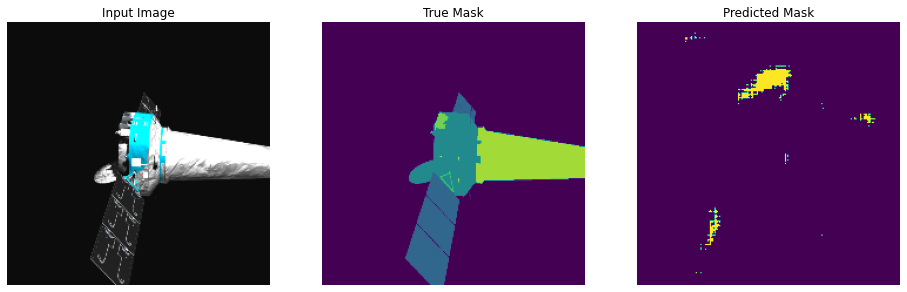

In [ ]:
def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions():
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]])
    
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask

show_predictions()

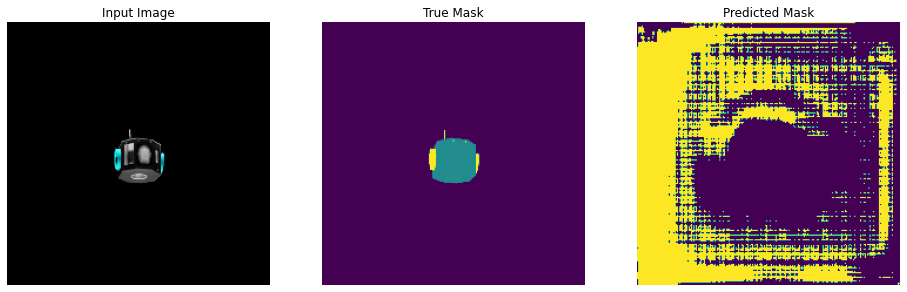

In [ ]:
def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions():
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]])
    
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask

show_predictions()

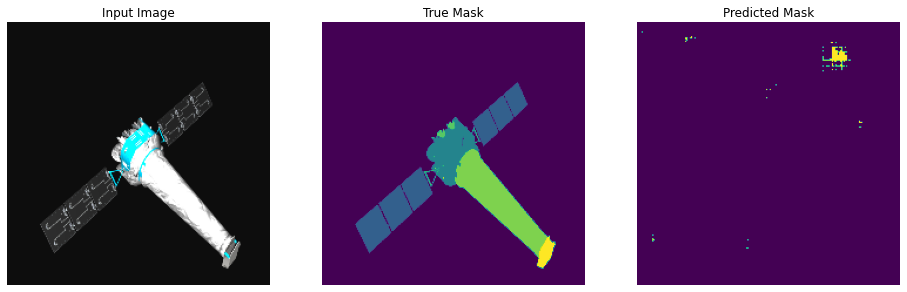

In [ ]:
def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions():
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]])
    
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask

show_predictions()

In [ ]:
test_steps = len(test_x)//batch
if len(test_x) % batch != 0: 
    test_steps += 1

result = model.evaluate(test_dataset, steps=test_steps)
dict(zip(model.metrics_names, result))

32/32 [==============================] - 7s 216ms/step - loss: 0.2243 - dice_coef: 0.7757 - accuracy: 0.3745


{'accuracy': 0.37450456619262695,
 'dice_coef': 0.7756887078285217,
 'loss': 0.22431139647960663}